In [1]:
!pip -q install yellowbrick==1.3

!pip -q install kneed
!pip -q install factor_analyzer
!pip -q install seaborn

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from factor_analyzer import FactorAnalyzer
from yellowbrick.features import PCA as YBPCA
from kneed import KneeLocator
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
#import plotly.express as px

In [2]:
#bike = pd.read_csv('../data/bike_clean.csv')
bike = pd.read_csv('bike_season_as_no.csv')
bike.head()

,Unnamed: 0,datetime,date,hour,season,holiday,open,rent_count,temperature,humidity,wind_speed,visibility,dewpoint_temp,solar_radiation,rainfall,snowfall,season_no
0,1,2017-12-01 00:00:00,2017-12-01,0,Winter,No Holiday,Yes,254,-5.2,37,2.2,20000,-17.6,0.0,0.0,0,4
1,2,2017-12-01 01:00:00,2017-12-01,1,Winter,No Holiday,Yes,204,-5.5,38,0.8,20000,-17.6,0.0,0.0,0,4
2,3,2017-12-01 02:00:00,2017-12-01,2,Winter,No Holiday,Yes,173,-6.0,39,1.0,20000,-17.7,0.0,0.0,0,4
3,4,2017-12-01 03:00:00,2017-12-01,3,Winter,No Holiday,Yes,107,-6.2,40,0.9,20000,-17.6,0.0,0.0,0,4
4,5,2017-12-01 04:00:00,2017-12-01,4,Winter,No Holiday,Yes,78,-6.0,36,2.3,20000,-18.6,0.0,0.0,0,4


In [3]:
# As PCA is a unsupervised learning algorithm, we will drop the Season column
# We will drop datetime and date as well since they are not numeric
bike2 = bike.copy()
#bike2.drop(columns = ['season','datetime','date','holiday','open','rent_count'],inplace=True)
bike2.drop(columns = ['season','datetime','date','holiday','open','rent_count','season_no'],inplace=True)
bike2.head()

,Unnamed: 0,hour,temperature,humidity,wind_speed,visibility,dewpoint_temp,solar_radiation,rainfall,snowfall
0,1,0,-5.2,37,2.2,20000,-17.6,0.0,0.0,0
1,2,1,-5.5,38,0.8,20000,-17.6,0.0,0.0,0
2,3,2,-6.0,39,1.0,20000,-17.7,0.0,0.0,0
3,4,3,-6.2,40,0.9,20000,-17.6,0.0,0.0,0
4,5,4,-6.0,36,2.3,20000,-18.6,0.0,0.0,0


In [4]:
# remvove first column
bike3 = bike2.iloc[: , 1:]
bike3.head()

,hour,temperature,humidity,wind_speed,visibility,dewpoint_temp,solar_radiation,rainfall,snowfall
0,0,-5.2,37,2.2,20000,-17.6,0.0,0.0,0
1,1,-5.5,38,0.8,20000,-17.6,0.0,0.0,0
2,2,-6.0,39,1.0,20000,-17.7,0.0,0.0,0
3,3,-6.2,40,0.9,20000,-17.6,0.0,0.0,0
4,4,-6.0,36,2.3,20000,-18.6,0.0,0.0,0


In [5]:
bike3

,hour,temperature,humidity,wind_speed,visibility,dewpoint_temp,solar_radiation,rainfall,snowfall
0,0,-5.2,37,2.2,20000,-17.6,0.0,0.0,0
1,1,-5.5,38,0.8,20000,-17.6,0.0,0.0,0
2,2,-6.0,39,1.0,20000,-17.7,0.0,0.0,0
3,3,-6.2,40,0.9,20000,-17.6,0.0,0.0,0
4,4,-6.0,36,2.3,20000,-18.6,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...
8755,19,4.2,34,2.6,18940,-10.3,0.0,0.0,0
8756,20,3.4,37,2.3,20000,-9.9,0.0,0.0,0
8757,21,2.6,39,0.3,19680,-9.9,0.0,0.0,0
8758,22,2.1,41,1.0,18590,-9.8,0.0,0.0,0


In [6]:
bike3.describe()

# we see each attributes have different ranges

,hour,temperature,humidity,wind_speed,visibility,dewpoint_temp,solar_radiation,rainfall,snowfall
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,11.500000,12.882922,58.226256,1.724909,14368.257991,4.073813,0.569111,0.148687,0.750685
std,6.922582,11.944825,20.362413,1.036300,6082.987120,13.060369,0.868746,1.128193,4.367462
min,0.000000,-17.800000,0.000000,0.000000,270.000000,-30.600000,0.000000,0.000000,0.000000
25%,5.750000,3.500000,42.000000,0.900000,9400.000000,-4.700000,0.000000,0.000000,0.000000
50%,11.500000,13.700000,57.000000,1.500000,16980.000000,5.100000,0.010000,0.000000,0.000000
75%,17.250000,22.500000,74.000000,2.300000,20000.000000,14.800000,0.930000,0.000000,0.000000
max,23.000000,39.400000,98.000000,7.400000,20000.000000,27.200000,3.520000,35.000000,88.000000


CHECK DATA
We want to check whether the data is suitable for PCA. We will use two tests, Bartlett's Sphericity Test and Kaiser Meyer Olkin (KMO) Test to check.

Bartlett's Sphericity Test

In [7]:
_ , p_value = calculate_bartlett_sphericity(bike3)
p_value

0.0

KMO Test

In [8]:
_, kmo_score = calculate_kmo(bike3)
kmo_score 

0.4425585420193913

We obtained a result < 0.05 for Bartlett's test and = 0.503 > 0.5 for KMO's. This means that conducting PCA on our data might be fruitful.

Scaling Data

In [9]:
#A common procedure is to centre each variable by subtracting its mean from every observation, and then rescale those 
#centred values as units of standard deviation. This is commonly called standardizing, normalizing, or Z scoring the data.
colnames = list(bike3.columns)

scaler = StandardScaler(with_mean=True,with_std=True)
scaled_features = pd.DataFrame(scaler.fit_transform(bike3))

scaled_features.columns = colnames

In [10]:
scaled_features.describe()

,hour,temperature,humidity,wind_speed,visibility,dewpoint_temp,solar_radiation,rainfall,snowfall
count,8.760000e+03,8.760000e+03,8.760000e+03,8.760000e+03,8.760000e+03,8.760000e+03,8.760000e+03,8.760000e+03,8.760000e+03
mean,2.027805e-19,9.733462e-17,1.362685e-16,-4.542282e-17,-2.595590e-17,-5.191180e-17,1.687133e-16,-1.216683e-18,1.297795e-17
std,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00
min,-1.661325e+00,-2.568868e+00,-2.859660e+00,-1.664583e+00,-2.317786e+00,-2.655039e+00,-6.551317e-01,-1.317999e-01,-1.718911e-01
25%,-8.306624e-01,-7.855668e-01,-7.969184e-01,-7.960588e-01,-8.167930e-01,-6.718274e-01,-6.551317e-01,-1.317999e-01,-1.718911e-01
50%,0.000000e+00,6.840822e-02,-6.022497e-02,-2.170429e-01,4.293764e-01,7.857709e-02,-6.436202e-01,-1.317999e-01,-1.718911e-01
75%,8.306624e-01,8.051710e-01,7.746943e-01,5.549784e-01,9.258713e-01,8.213244e-01,4.154376e-01,-1.317999e-01,-1.718911e-01
max,1.661325e+00,2.220090e+00,1.953404e+00,5.476614e+00,9.258713e-01,1.770816e+00,3.396916e+00,3.089303e+01,1.997826e+01


In [11]:
corr = scaled_features.corr()
corr


,hour,temperature,humidity,wind_speed,visibility,dewpoint_temp,solar_radiation,rainfall,snowfall
hour,1.000000,0.124114,-0.241644,0.285197,0.098753,0.003054,0.145131,0.008715,-0.021516
temperature,0.124114,1.000000,0.159371,-0.036252,0.034794,0.912798,0.353505,0.050282,-0.218405
humidity,-0.241644,0.159371,1.000000,-0.336683,-0.543090,0.536894,-0.461919,0.236397,0.108183
wind_speed,0.285197,-0.036252,-0.336683,1.000000,0.171507,-0.176486,0.332274,-0.019674,-0.003554
visibility,0.098753,0.034794,-0.543090,0.171507,1.000000,-0.176630,0.149738,-0.167629,-0.121695
dewpoint_temp,0.003054,0.912798,0.536894,-0.176486,-0.176630,1.000000,0.094381,0.125597,-0.150887
solar_radiation,0.145131,0.353505,-0.461919,0.332274,0.149738,0.094381,1.000000,-0.074290,-0.072301
rainfall,0.008715,0.050282,0.236397,-0.019674,-0.167629,0.125597,-0.074290,1.000000,0.008500
snowfall,-0.021516,-0.218405,0.108183,-0.003554,-0.121695,-0.150887,-0.072301,0.008500,1.000000


<AxesSubplot:>

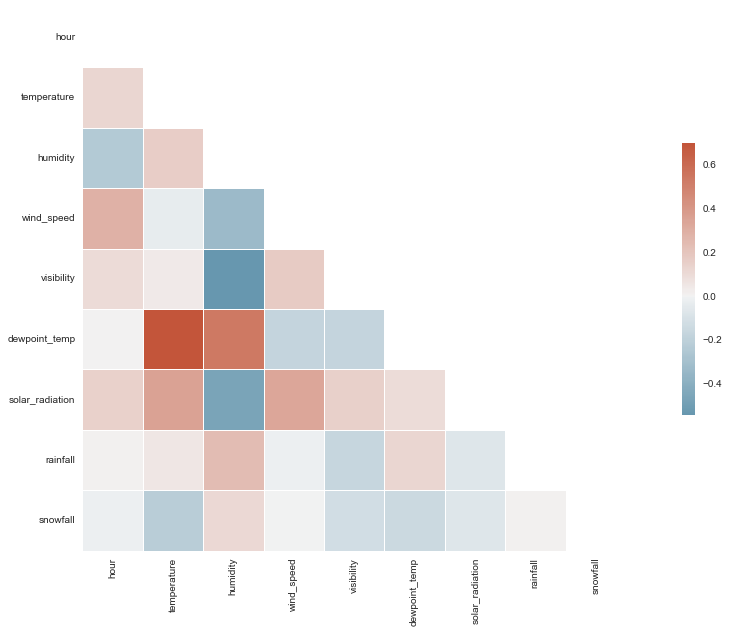

In [12]:
plt.subplots(figsize=(20, 10))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

mask = np.triu(np.ones_like(corr, dtype=bool))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,cmap=cmap,vmax =0.7, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

dewpoint_temperature and temperature are highly correlated at 0.913. May consider dropping either!

CUMULATIVE VARIANCE AND SCREE PLOT

In [13]:
#We will set n_components to 10

N = 9
pca = PCA(n_components=N)
pca.fit(scaled_features)

PCA(n_components=9)

In [14]:
#outputs an array of the variance explained by each component scaled to the total of 1.
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_ratio

array([0.2715419 , 0.2273595 , 0.12722346, 0.10451174, 0.09298065,
       0.08431787, 0.06826455, 0.02329447, 0.00050586])

In [15]:
# Cumulative sum of principal components i.e. Cumulative variance of 2 = PC1 variance + PC2 variance
cumulative_variance = np.cumsum(np.round(explained_variance_ratio, decimals=3))
cumulative_variance

array([0.272, 0.499, 0.626, 0.731, 0.824, 0.908, 0.976, 0.999, 1.   ])

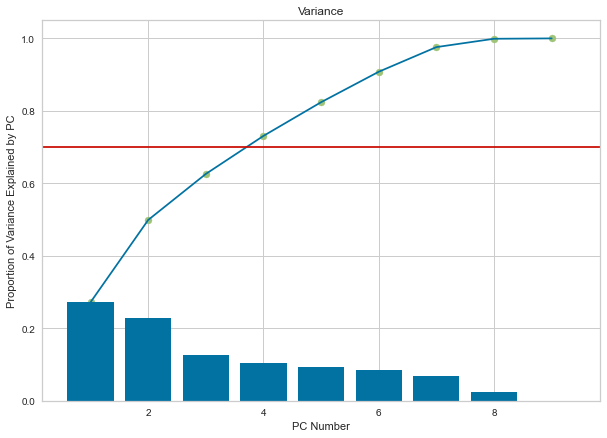

In [16]:
x = list(range(1,N+1))
plt.figure(figsize=(10, 7)) 
plt.bar(x,explained_variance_ratio)
plt.scatter(range(1,N+1),cumulative_variance)
plt.plot(x,cumulative_variance)
plt.title('Variance')
plt.xlabel('PC Number')
plt.ylabel('Proportion of Variance Explained by PC')
plt.axhline(y=0.7, color = 'r')

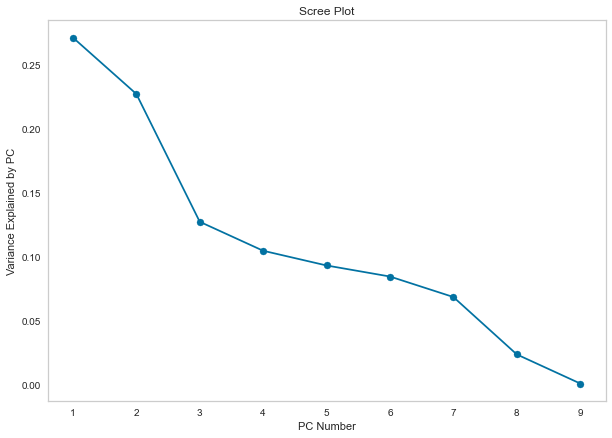

In [17]:
#Scree Plot 
plt.figure(figsize=(10, 7)) 
plt.scatter(range(1,N+1),pca.explained_variance_ratio_)
plt.plot(range(1,N+1),pca.explained_variance_ratio_)
plt.title('Scree Plot')
plt.xlabel('PC Number')
plt.ylabel('Variance Explained by PC')
plt.grid()

In [18]:
kl = KneeLocator(range(1, N+1), pca.explained_variance_ratio_, curve="convex", direction="decreasing")

kl.elbow

3

PCA on Scaled Features

In [22]:
# factor analysis
def evaluate_pcs(num_of_pcs,data):
    def encode_vals(x): #helper functions to suppress loading less than 0.7 
    #a gradual process to lead to this function
    # if x<=-0.5, we drop the variable
        if x <= -0.5 or x >= 0.5: #Adjust the threshold value 
            return x
        else:
            return("")    
    f = FactorAnalyzer(n_factors=num_of_pcs, method = 'principal',rotation='varimax') #Conduct PCA + varimax rotation to extract latent factors 
    f.fit(data)
    loadings = pd.DataFrame(f.loadings_).set_index(data.columns)
    loadings = loadings.applymap(encode_vals)
    loadingcols= list(loadings.columns)
    newcols = {}
    for i in loadingcols:
        newcols[i] = "PC" + str(i+1)
    loadings.rename(columns = newcols,inplace=True)
    
    
    df_pca = f.transform(data)
    return loadings , df_pca

# The following function generates the rotation matrix. Recall that we use
# this matrix to determine if the PCs generated are easily understandable and appropriate.
# The argument "num_of_pcs" specifies, the number of PCs we wish to generate.

In [23]:
def CronbachAlpha(itemscores): #calculate the CronbachAlpha to see how closely related a set of items are as a group
    itemscores = np.asarray(itemscores)
    itemvars = itemscores.var(axis=0, ddof=1)
    tscores = itemscores.sum(axis=1)
    nitems = itemscores.shape[1]
    return (nitems / (nitems-1)) * (1 - (itemvars.sum() / tscores.var(ddof=1)))

In [24]:
pca_label, df_pca_array =evaluate_pcs(3,scaled_features[colnames])
pca_label
# from the elbow plot

,PC1,PC2,PC3
hour,,0.670231,
temperature,0.958516,,
humidity,,-0.529101,0.676376
wind_speed,,0.755572,
visibility,,,-0.707501
dewpoint_temp,0.943591,,
solar_radiation,,0.623373,
rainfall,,,0.594017
snowfall,,,


In [28]:
df_pca = pd.DataFrame(df_pca_array, columns =['PC1','PC2','PC3'])
df_pca

,PC1,PC2,PC3
0,-1.570527,-0.667987,-1.114731
1,-1.474512,-1.244913,-1.268555
2,-1.505612,-1.104340,-1.192094
3,-1.497112,-1.096917,-1.158918
4,-1.643805,-0.364000,-0.998120
...,...,...,...
8755,-1.020747,0.792107,-0.456898
8756,-0.995433,0.683950,-0.491632
8757,-0.870994,-0.174429,-0.690753
8758,-0.931926,0.183404,-0.447680


In [269]:
print(CronbachAlpha(scaled_features[['temperature','dewpoint_temp']])) #Reliability of PC1
print(CronbachAlpha(scaled_features[['hour','wind_speed','solar_radiation']])) #Reliability of PC2
print(CronbachAlpha(scaled_features[['humidity','rainfall']]))
#Reliability for all the features
#If we had a diff sample, would we still get these 4PCs with the same features with high loadings


# Now, on to test the reliability of the PCs using Cronbach's alpha, which is a
# measure of the internal consistency of the PCs. The higher their internal
# consistencies, the greater the chance the loadings generated using other
# samples of this data will be similar.

# Only first result is greater than our minimum requirement of 0.70. This means only
# PC1 generated is reliable. Hence rerunning the pca with the respective variables remove is not helpful.

0.9544114060820124
0.5055696170015211
0.38239616144398547


In [270]:
df_wo_vis = scaled_features.drop(columns = ['visibility'])
df_wo_vis.head()

,hour,temperature,humidity,wind_speed,dewpoint_temp,solar_radiation,rainfall,snowfall
0,-1.661325,-1.513957,-1.042483,0.458476,-1.659605,-0.655132,-0.1318,-0.171891
1,-1.516862,-1.539074,-0.993370,-0.892561,-1.659605,-0.655132,-0.1318,-0.171891
2,-1.372399,-1.580936,-0.944257,-0.699556,-1.667262,-0.655132,-0.1318,-0.171891
3,-1.227936,-1.597680,-0.895144,-0.796059,-1.659605,-0.655132,-0.1318,-0.171891
4,-1.083473,-1.580936,-1.091596,0.554978,-1.736177,-0.655132,-0.1318,-0.171891


In [271]:
N = 8 # now max 8 variables
model3 = PCA(n_components=N)
model3.fit(df_wo_vis)
explained_variance3 = model3.explained_variance_ratio_ #Explained Variance Ratio for each Principal Component, sums to 1.

explained_variance3

array([0.28416318, 0.24393607, 0.1340602 , 0.11645841, 0.10456223,
       0.08024899, 0.03599775, 0.00057317])

In [213]:
cumulative_variance3 = np.cumsum(np.round(explained_variance3, decimals=3))

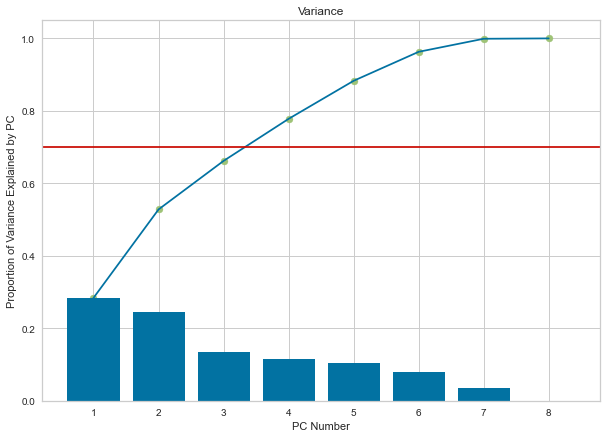

In [214]:
x = list(range(1,N+1))
plt.figure(figsize=(10, 7)) 
plt.bar(x,explained_variance3)
plt.scatter(range(1,N+1),cumulative_variance3)
plt.plot(x,cumulative_variance3)
plt.title('Variance')
plt.xlabel('PC Number')
plt.ylabel('Proportion of Variance Explained by PC')
plt.axhline(y=0.7, color='r')

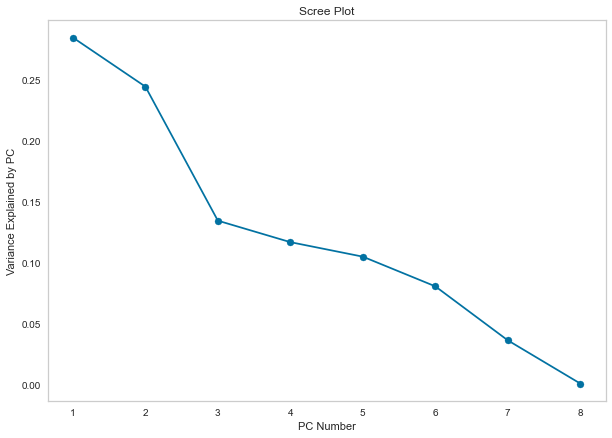

In [215]:
#Scree Plot 
plt.figure(figsize=(10, 7)) 
plt.scatter(range(1,N+1),explained_variance3)
plt.plot(range(1,N+1),explained_variance3)
plt.title('Scree Plot')
plt.xlabel('PC Number')
plt.ylabel('Variance Explained by PC')
plt.grid()

In [216]:
kl3 = KneeLocator(range(1, N+1), model3.explained_variance_ratio_, curve="convex", direction="decreasing")
kl3.elbow

3

In [217]:
evaluate_pcs(3,df_wo_vis)

,PC1,PC2,PC3
hour,,0.657618,
temperature,0.953306,,
humidity,,-0.621059,0.505475
wind_speed,,0.748323,
dewpoint_temp,0.967234,,
solar_radiation,,0.652563,
rainfall,,,0.736495
snowfall,,,


In [218]:
print(CronbachAlpha(scaled_features[['temperature','dewpoint_temp']])) #Reliability of PC1
print(CronbachAlpha(scaled_features[['hour','wind_speed','solar_radiation']])) #Reliability of PC1
print(CronbachAlpha(scaled_features[['humidity','rainfall']])) #Reliability of PC1

0.9544114060820124
0.5055696170015211
0.38239616144398547
